In [ ]:
from helpers.plots import plot_toy_signals
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

# Feature Selection on a Quantum Computer

# MIQUBO on the Predicting Survival of Titanic Passengers

In [ ]:
titanic = pd.read_csv("data/formatted_titanic.csv") # To see the data folder's contents, select Jupyter File Explorer View from the Online Learning page

Plot a ranking of MI between each feature and the variable of interest (survival).

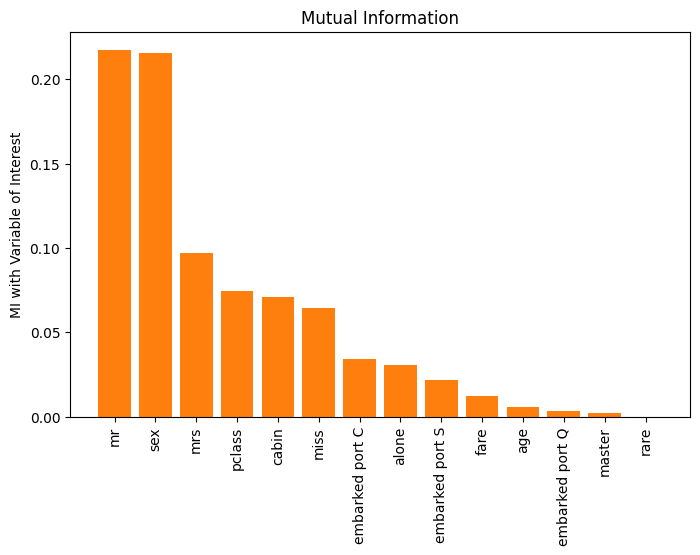

In [ ]:
mi = {}
features = list(set(titanic.columns).difference(('survived',)))

for feature in features:
    mi[feature] = mutual_information(prob(titanic[['survived', feature]].values), 1)

plot_mi(mi)

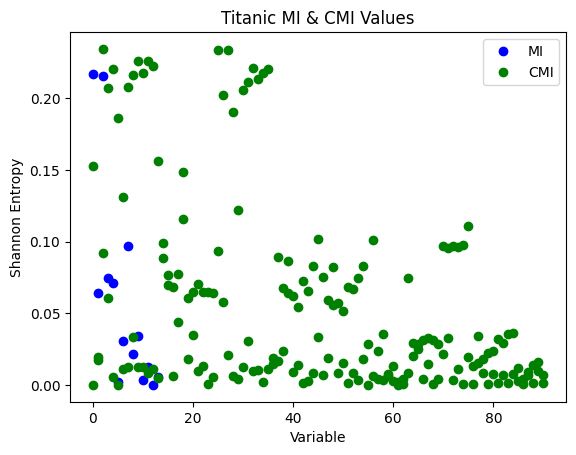

In [ ]:
plt.plot(range(len(features)), [mutual_information(prob(titanic[['survived', feature]].values), 1) for feature in features], 'bo')

plt.plot(range(len([x for x in itertools.combinations(features, 2)])), [conditional_mutual_information(prob(titanic[['survived', f0, f1]].values), 1, 2) for f0, f1 in itertools.combinations(features, 2)], 'go')
plt.plot(range(len([x for x in itertools.combinations(features, 2)])), [conditional_mutual_information(prob(titanic[['survived', f1, f0]].values), 1, 2) for f0, f1 in itertools.combinations(features, 2)], 'go')

plt.title("Titanic MI & CMI Values")
plt.ylabel("Shannon Entropy")
plt.xlabel("Variable")
plt.legend(["MI", "CMI"])

The plot below, obtained by exploiting the problem's small size and brute-force solving for all possible values, shows the solution space for a couple of choices of $k$. The left side shows the resulting energy for all possible assignments of values to $x_1...x_N$ (yellow) and those that satisfy the requirement of $n \choose k$ (blue); the right side focuses on only those that satisfy $n \choose k$ and highlights the optimal solution (red).

<img src="images/k4_7_solution_space.png" width=800x>

## Building the MI-Based BQM
Select 8 features with the top MI ranking found above. 

In [ ]:
keep = 8

sorted_mi = sorted(mi.items(), key=lambda pair: pair[1], reverse=True)
titanic = titanic[[column[0] for column in sorted_mi[0:keep]] + ["survived"]]
features = list(set(titanic.columns).difference(('survived',)))

print("Submitting for {} features: {}".format(keep, features))

Submitting for 8 features: ['mr', 'miss', 'sex', 'cabin', 'alone', 'mrs', 'embarked port C', 'pclass']


Calculate a BQM based on the problem's MI and CMI as done previously for the toy problem.

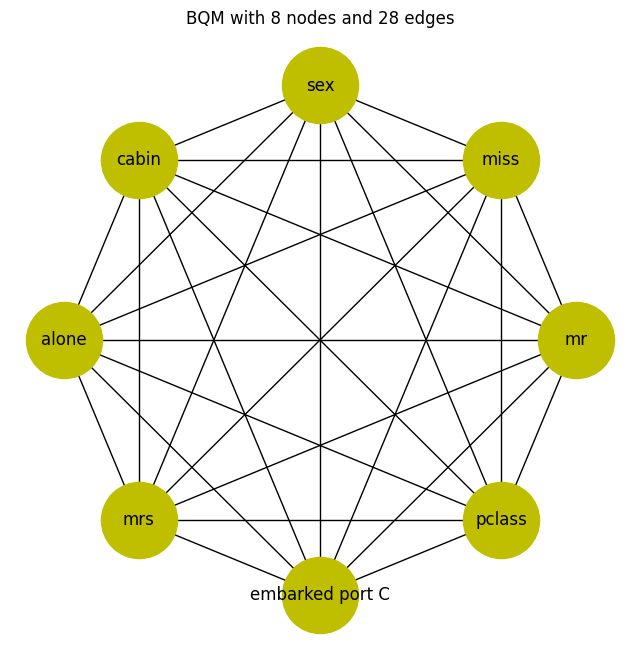

In [ ]:
from helpers.draw import plot_bqm 

bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

# add the features
for feature in features:
    mi = mutual_information(prob(titanic[['survived', feature]].values), 1)
    bqm.add_variable(feature, -mi)

for f0, f1 in itertools.combinations(features, 2):
    cmi_01 = conditional_mutual_information(prob(titanic[['survived', f0, f1]].values), 1, 2)
    cmi_10 = conditional_mutual_information(prob(titanic[['survived', f1, f0]].values), 1, 2)
    bqm.add_interaction(f0, f1, -cmi_01)
    bqm.add_interaction(f1, f0, -cmi_10)

bqm.normalize()  

plot_bqm(bqm)

## Setting Up a QPU as a Solver

In [ ]:
from dwave.system import DWaveSampler, FixedEmbeddingComposite
from minorminer.busclique import find_clique_embedding

qpu = DWaveSampler()

qpu_working_graph = qpu.to_networkx_graph()
embedding = find_clique_embedding(bqm.variables, qpu_working_graph)

qpu_sampler = FixedEmbeddingComposite(qpu, embedding)

print("Maximum chain length for minor embedding is {}.".format(max(len(x) for x in embedding.values())))

Maximum chain length for minor embedding is 2.


This problem is small enough to be solved in its entirety on a D-Wave 2000Q QPU. For datasets with higher numbers of features, D-Wave Ocean's [dwave-hybrid](https://docs.ocean.dwavesys.com/en/stable/docs_hybrid/sdk_index.html) tool can be used to break the BQM into smaller pieces for serial submission to the QPU and/or parallel solution on classical resources. Here, an out-of-the-box hybrid sampler, [Kerberos](https://docs.ocean.dwavesys.com/en/stable/docs_hybrid/reference/reference.html) is used.    

In [ ]:
from hybrid.reference.kerberos import KerberosSampler

kerberos_sampler = KerberosSampler() 

## Submit the Problem for All k Values

In [ ]:
from helpers.draw import plot_feature_selection 

selected_features = np.zeros((len(features), len(features)))
for k in range(1, len(features) + 1):
    print("Submitting for k={}".format(k))
    kbqm = dimod.generators.combinations(features, k, strength=6)
    kbqm.update(bqm)
    kbqm.normalize()
    
    best = kerberos_sampler.sample(kbqm, 
                                   qpu_sampler=qpu_sampler, 
                                   qpu_reads=10000, 
                                   max_iter=1,
                                   qpu_params={'label': 'Notebook - Feature Selection'}
                                  ).first.sample
    
    for fi, f in enumerate(features):
        selected_features[k-1, fi] = best[f]

plot_feature_selection(features, selected_features)

Submitting for k=1


SolverFailureError: The problem cannot be submitted because its estimated QPU access time of 1392656 microseconds exceeds the maximum of 1000000 microseconds for Advantage_system4.1. To resolve this issue, see the topic at https://docs.dwavesys.com/docs/latest/c_qpu_timing.html#keeping-within-the-runtime-limit.

# Reference:

1. [D-Wave Feature Selection example](https://green-kangaroo-0bqmh1vu.ws.ide.dwavesys.io/)